# **Skin Disease Classification**

# Import Library

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, DenseNet121, VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
from google.colab import files
import zipfile
from tqdm.notebook import tqdm as tq
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Data Preparation

## Data Loading

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"najwatiara","key":"fbd5e395d48632fe905bea3145065ded"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mgmitesh/skin-disease-detection-dataset
!unzip skin-disease-detection-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/Vascular Lesion/ISIC_0024370.jpg  
  inflating: train/Vascular Lesion/ISIC_0024375.jpg  
  inflating: train/Vascular Lesion/ISIC_0024402.jpg  
  inflating: train/Vascular Lesion/ISIC_0024662.jpg  
  inflating: train/Vascular Lesion/ISIC_0024867.jpg  
  inflating: train/Vascular Lesion/ISIC_0024904.jpg  
  inflating: train/Vascular Lesion/ISIC_0025197.jpg  
  inflating: train/Vascular Lesion/ISIC_0025249.jpg  
  inflating: train/Vascular Lesion/ISIC_0025250.jpg  
  inflating: train/Vascular Lesion/ISIC_0025425.jpg  
  inflating: train/Vascular Lesion/ISIC_0025578.jpg  
  inflating: train/Vascular Lesion/ISIC_0025596.jpg  
  inflating: train/Vascular Lesion/ISIC_0025606.jpg  
  inflating: train/Vascular Lesion/ISIC_0025612.jpg  
  inflating: train/Vascular Lesion/ISIC_0025677.jpg  
  inflating: train/Vascular Lesion/ISIC_0025680.jpg  
  inflating: train/Vascular Lesion/ISIC_0025807.jpg  
  inflating: train/Vasc

## Data Prepocessing

In [ ]:
# Direktor awal untuk train dan val
train_dir = 'train'
val_dir = 'val'
# Direkturi baru untuk dataset gabungan
merged_dir = 'dataset'

In [ ]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(merged_dir, exist_ok=True)

In [ ]:
# Salin file dari train dan val ke dataset gabungan
for category in os.listdir(train_dir):
    src = os.path.join(train_dir, category)
    dst = os.path.join(merged_dir, category)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)

for category in os.listdir(val_dir):
    src = os.path.join(val_dir, category)
    dst = os.path.join(merged_dir, category)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)

In [ ]:
print("\nIsi folder dataset:")
for cls in os.listdir(merged_dir):
    print(f"{cls}: {len(os.listdir(os.path.join(merged_dir, cls)))} gambar")


Isi folder dataset:
Normal Skin: 3337 gambar
Basal Cell Carcinoma: 3103 gambar
Dyshidrotic Eczema: 2925 gambar
Squamous Cell Carcinoma: 2909 gambar
Acne: 3604 gambar
Pigmented Benign Keratosis: 3018 gambar
Chickenpox: 3301 gambar
Actinic Keratosis: 3252 gambar
Dermato Fibroma: 3131 gambar
Nail Fungus: 3121 gambar
Ringworm: 3229 gambar
Seborrheic Keratosis: 2921 gambar
Nevus: 3978 gambar
Vascular Lesion: 3108 gambar
Melanoma: 3213 gambar


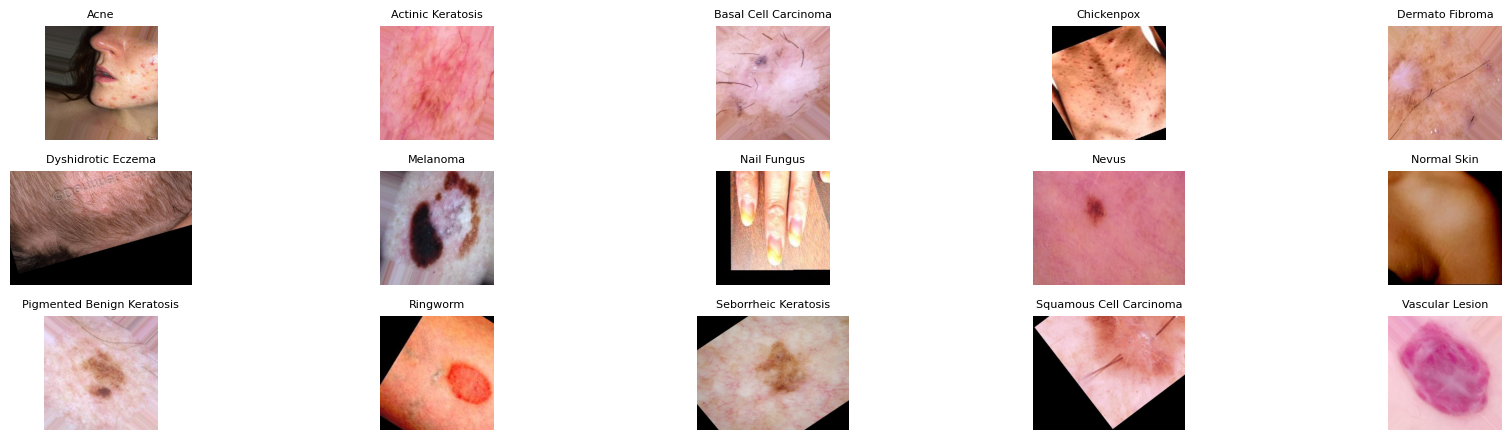

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas
skin_image = {}

# Path dataset
path = "dataset"

# Kumpulkan gambar dari setiap kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        skin_image[class_name] = os.listdir(class_path)

# Jumlah kelas
num_classes = len(skin_image)

# Tetapkan jumlah baris dan kolom
rows = 3
cols = 5

# Buat subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(18, rows * 1.5))
axs = axs.flatten()  # Ubah ke list agar mudah diakses

# Tampilkan satu gambar acak per kelas
for i, class_name in enumerate(sorted(skin_image.keys())):
    if i >= rows * cols:
        break  # Hentikan jika jumlah subplot melebihi kapasitas grid
    images = skin_image[class_name]
    if images:
        image_name = random.choice(images)
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i].imshow(img)
        axs[i].set_title(class_name, fontsize=8)
        axs[i].axis('off')
    else:
        axs[i].set_title(f"{class_name} (No images)")
        axs[i].axis('off')

# Kosongkan subplot yang tidak terpakai
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

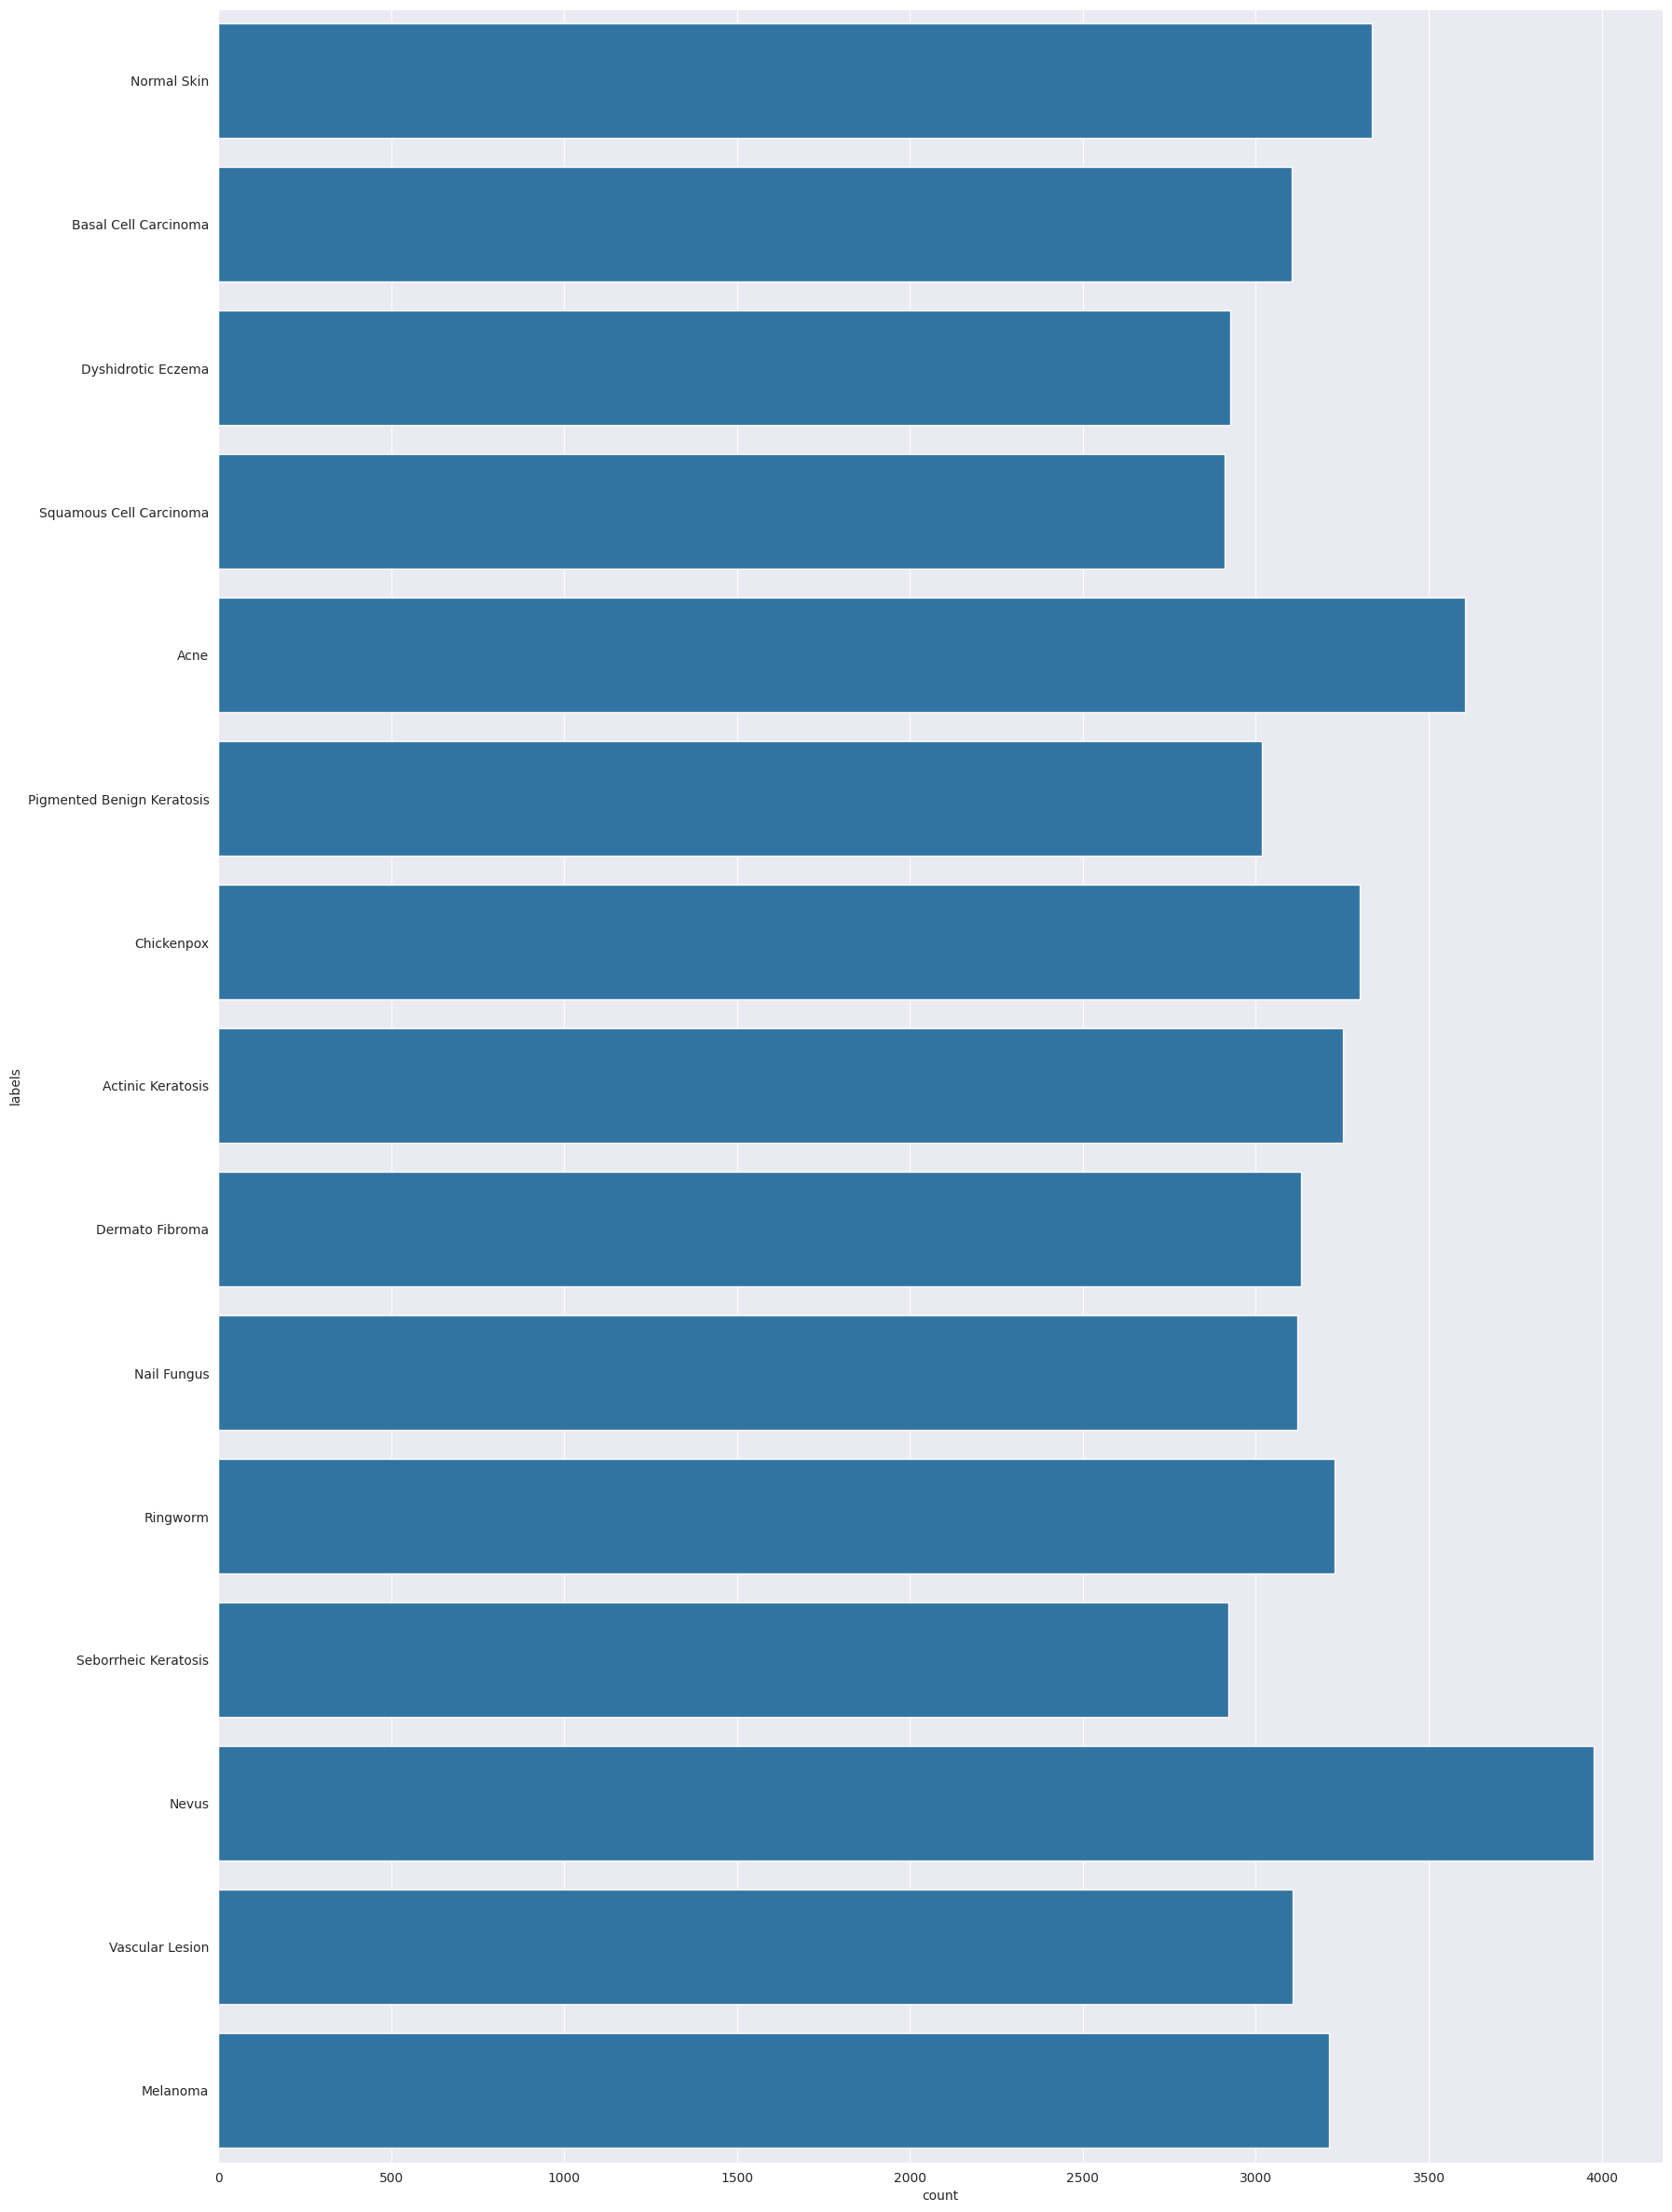

In [ ]:
# Definisi path sumber
skin_path = 'dataset'

# Membuat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(skin_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (20,30))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Acne,3604
Actinic Keratosis,3252
Basal Cell Carcinoma,3103
Chickenpox,3301
Dermato Fibroma,3131
Dyshidrotic Eczema,2925
Melanoma,3213
Nail Fungus,3121
Nevus,3978


In [ ]:
# Definisi X dan y
X = df['path']
y = df['labels']

In [ ]:
# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "dataset"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels                    
test   Acne                           721
       Actinic Keratosis              650
       Basal Cell Carcinoma           620
       Chickenpox                     660
       Dermato Fibroma                626
       Dyshidrotic Eczema             585
       Melanoma                       643
       Nail Fungus                    624
       Nevus                          796
       Normal Skin                    667
       Pigmented Benign Keratosis     604
       Ringworm                       646
       Seborrheic Keratosis           584
       Squamous Cell Carcinoma        582
       Vascular Lesion                622
train  Acne                          2883
       Actinic Keratosis             2602
       Basal Cell Carcinoma          2483
       Chickenpox                    2641
       Dermato Fibroma               2505
       Dyshidrotic Eczema            2340
       Melanoma                      2570
       Nail Fungus                   2497

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Definisikan direktori train dan test
train_set = "Dataset-Final/train/"
test_set = "Dataset-Final/test/"

# Ambil semua nama kelas (subfolder)
classes = sorted(os.listdir(train_set))  # diasumsikan semua kelas sama di train & test

print("Jumlah kelas ditemukan:", len(classes))
print("\n=== Jumlah gambar per kelas (TRAIN) ===")
for class_name in classes:
    class_path = os.path.join(train_set, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name:<20}: {num_images} gambar")

print("\n=== Jumlah gambar per kelas (TEST) ===")
for class_name in classes:
    class_path = os.path.join(test_set, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name:<20}: {num_images} gambar")

Jumlah kelas ditemukan: 15

=== Jumlah gambar per kelas (TRAIN) ===
Acne                : 2883 gambar
Actinic Keratosis   : 2602 gambar
Basal Cell Carcinoma: 2483 gambar
Chickenpox          : 2641 gambar
Dermato Fibroma     : 2505 gambar
Dyshidrotic Eczema  : 2340 gambar
Melanoma            : 2570 gambar
Nail Fungus         : 2497 gambar
Nevus               : 3182 gambar
Normal Skin         : 2670 gambar
Pigmented Benign Keratosis: 2414 gambar
Ringworm            : 2583 gambar
Seborrheic Keratosis: 2337 gambar
Squamous Cell Carcinoma: 2327 gambar
Vascular Lesion     : 2486 gambar

=== Jumlah gambar per kelas (TEST) ===
Acne                : 721 gambar
Actinic Keratosis   : 650 gambar
Basal Cell Carcinoma: 620 gambar
Chickenpox          : 660 gambar
Dermato Fibroma     : 626 gambar
Dyshidrotic Eczema  : 585 gambar
Melanoma            : 643 gambar
Nail Fungus         : 624 gambar
Nevus               : 796 gambar
Normal Skin         : 667 gambar
Pigmented Benign Keratosis: 604 gambar
Ring

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 30821 images belonging to 15 classes.
Found 7699 images belonging to 15 classes.
Found 9630 images belonging to 15 classes.


# Pemodelan

In [ ]:
# Class weight
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

callbacks = [early_stop, reduce_lr]

In [ ]:
# Transfer learning dengan MobileNet
base_model =  MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Fine-tune 50 layer terakhir
for layer in base_model.layers[-50:]:
    layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Bangun model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,951 (9.28 MB)

 Trainable params: 2,028,687 (7.74 MB)

 Non-trainable params: 403,264 (1.54 MB)

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 637s 633ms/step - accuracy: 0.5048 - loss: 1.6656 - val_accuracy: 0.6453 - val_loss: 1.1435 - learning_rate: 1.0000e-04
Epoch 2/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 572s 594ms/step - accuracy: 0.8069 - loss: 0.6422 - val_accuracy: 0.7175 - val_loss: 0.9477 - learning_rate: 1.0000e-04
Epoch 3/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 553s 573ms/step - accuracy: 0.8665 - loss: 0.4575 - val_accuracy: 0.7281 - val_loss: 1.1443 - learning_rate: 1.0000e-04
Epoch 4/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 552s 573ms/step - accuracy: 0.9021 - loss: 0.3409 - val_accuracy: 0.7367 - val_loss: 1.0937 - learning_rate: 1.0000e-04
Epoch 5/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 568s 589ms/step - accuracy: 0.9170 - loss: 0.2841 - val_accuracy: 0.7483 - val_loss: 1.1538 - learning_rate: 1.0000e-04
Epoch 6/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 549s 569ms/step - accuracy: 0.9273 - loss: 0.2532 - val_accuracy: 0.7393 - val_loss: 1.2393 - learning_rate: 1.0000e-04
Epoch 7/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 

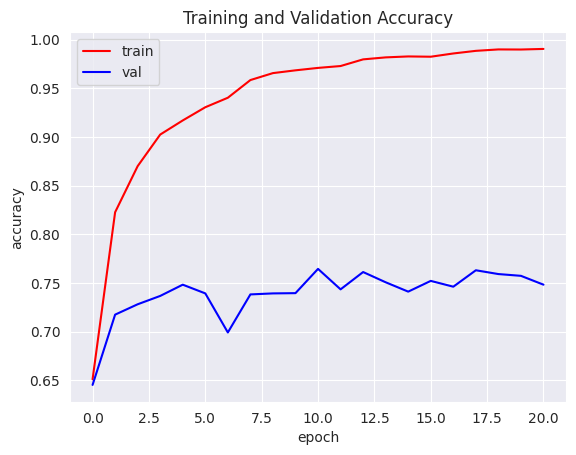

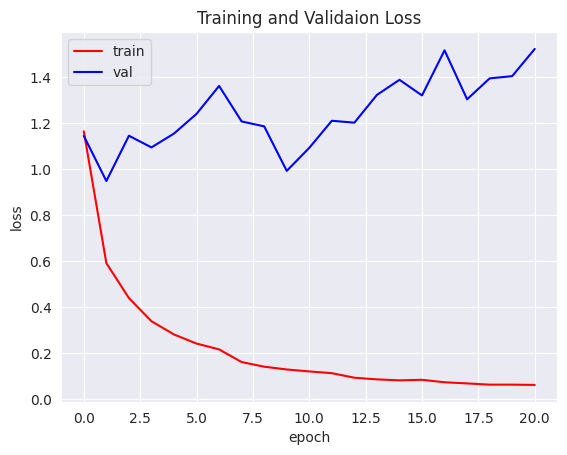

In [ ]:
# Visualisasi metrik evaluasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
# Evaluasi akurasi pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluasi akurasi pada train set
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.8960 - loss: 0.5043
Test Accuracy: 91.03%
964/964 ━━━━━━━━━━━━━━━━━━━━ 426s 442ms/step - accuracy: 0.9807 - loss: 0.0850
Train Accuracy: 98.10%


# Konversi Model

In [ ]:
# Simpan model HDF5 format
model.save('model.h5')